# DA5401 A5: Visualizing Data Veracity Challenges in Multi-Label Classification
### Objective: 
This assignment aims to deepen your understanding of the challenges in real-world machine
learning, specifically in multi-label classification, by utilizing advanced non-linear dimensionality
reduction techniques such as t-SNE and Isomap. You will visually inspect the data for issues such as
noisy labels, outliers, and hard-to-learn data points, sparking curiosity about data veracity in a biological
context.

## 1. Problem Statement
You are a data scientist analyzing gene expression data. You have been given the Yeast Dataset, where
each data point (instance) represents an experiment, and the features are gene expression levels. The
target is a set of 14 functional categories (labels) to which the gene product may belong (multi-label
classification). This dataset, despite being standardized, can still exhibit data veracity issues:
1. Noisy/Ambiguous Labels: Genes whose functions span multiple categories or are misclassified.
2. Outliers: Experiments with highly unusual gene expression profiles.
3. Hard-to-Learn Samples: Data points lying in regions where functional categories are thoroughly
mixed.
Your task is to apply t-SNE and Isomap to the feature vectors to visually expose these data quality
issues, thereby understanding the challenges a classifier would face.
You will submit a Jupyter Notebook with your complete code, visualizations, and a plausible story that
explains your findings. The notebook should be well-commented, reproducible, and easy to follow.
### Dataset:
- Yeast Dataset: The feature matrix X and the binary multi-label matrix Y (with 14 labels) are
standard files available from the Mulan Repository or other machine learning data repositories.
- Download Link (Example Source - use the text files): MULAN Repository (https://mulan.sourceforge.net/datasets-mlc.html) - Yeast Data (Look
for yeast.arff and the corresponding label file, or a pre-converted CSV/NumPy format).

## 2. Tasks

### Part A: Preprocessing and Initial Setup

In [10]:
# Data Loading : Load the feature matrix X (103 features) and the multi-label target matrix Y (14labels).

import pandas as pd
import arff
import xml.etree.ElementTree as ET

# -----------------------------
# 1. Data Loading [2]: Load the feature matrix X (86 features) and the multi-label target matrix Y (14 labels).
# -----------------------------
arff_path = "/Users/navaneethakrishnan/Desktop/DAL/assignment_5_Navaneeth272001/yeast/yeast.arff"
dataset = arff.load(open(arff_path))
df = pd.DataFrame(dataset['data'], columns=[attr[0] for attr in dataset['attributes']])

for col in df.select_dtypes(['object']).columns:
    df[col] = df[col].apply(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)

print("Full DataFrame shape:", df.shape)
print("Columns:", df.columns.tolist()[:10], "...")  

xml_path = "/Users/navaneethakrishnan/Desktop/DAL/assignment_5_Navaneeth272001/yeast/yeast.xml"
tree = ET.parse(xml_path)
root = tree.getroot()
labels = [elem.text for elem in root.findall(".//label/name")]
print("Labels from XML:", labels)

# --- If XML labels are missing, detect them manually ---
if not labels:
    labels = [col for col in df.columns if col.lower().startswith("class")]

print("Using label columns:", labels)

Y = df[labels].astype(int)
X = df.drop(columns=labels)

# -----------------------------
# 2. Dimensionality Check: Report the initial number of features and the number of data points.
# -----------------------------
print("\nFeature matrix X shape:", X.shape)
print("Target matrix Y shape:", Y.shape)

print("\nSample feature columns:", X.columns[:5].tolist())
print("Sample label columns:", Y.columns.tolist())
print("\nSample X rows:\n", X.head())
print("\nSample Y rows:\n", Y.head())



Full DataFrame shape: (2417, 117)
Columns: ['Att1', 'Att2', 'Att3', 'Att4', 'Att5', 'Att6', 'Att7', 'Att8', 'Att9', 'Att10'] ...
Labels from XML: []
Using label columns: ['Class1', 'Class2', 'Class3', 'Class4', 'Class5', 'Class6', 'Class7', 'Class8', 'Class9', 'Class10', 'Class11', 'Class12', 'Class13', 'Class14']

Feature matrix X shape: (2417, 103)
Target matrix Y shape: (2417, 14)

Sample feature columns: ['Att1', 'Att2', 'Att3', 'Att4', 'Att5']
Sample label columns: ['Class1', 'Class2', 'Class3', 'Class4', 'Class5', 'Class6', 'Class7', 'Class8', 'Class9', 'Class10', 'Class11', 'Class12', 'Class13', 'Class14']

Sample X rows:
        Att1      Att2      Att3      Att4      Att5      Att6      Att7  \
0  0.004168 -0.170975 -0.156748 -0.142151  0.058781  0.026851  0.197719   
1 -0.103956  0.011879 -0.098986 -0.054501 -0.007970  0.049113 -0.030580   
2  0.509949  0.401709  0.293799  0.087714  0.011686 -0.006411 -0.006255   
3  0.119092  0.004412 -0.002262  0.072254  0.044512 -0.051467 

In [11]:
# --------------------------------------------- #
#3. Label Selection for Visualization: To simplify the visualization (since 14 colors can be overwhelming), create a new target variable for coloring that represents the two most frequent single-label classes and the most frequent multi-label combination. Assign an "Other" category to the rest. This approach creates a simple, distinct categorical index for coloring the plots.
# --------------------------------------------- #

label_combinations = Y.apply(lambda row: tuple(Y.columns[row == 1]), axis=1) # Convert each row of Y into a tuple of active labels
combo_counts = label_combinations.value_counts() # Count occurrences of each combination

print("\nTop 10 label combinations:")
print(combo_counts.head(10))

# Separate single-label and multi-label entries
single_label_combos = combo_counts[combo_counts.index.map(len) == 1]
multi_label_combos = combo_counts[combo_counts.index.map(len) > 1]
top_single_labels = single_label_combos.head(2).index.tolist() # Get the two most frequent single labels
print("\nMost frequent single-labels:", top_single_labels)

top_multi_label = multi_label_combos.head(1).index[0] if not multi_label_combos.empty else None # Get the most frequent multi-label combination
print("Most frequent multi-label combination:", top_multi_label)

def label_group(row):
    labels_present = tuple(Y.columns[row == 1])
    if labels_present in top_single_labels:
        return labels_present[0]  # single label name
    elif labels_present == top_multi_label:
        return "+".join(top_multi_label)
    else:
        return "Other"

visual_label = Y.apply(label_group, axis=1)

X_viz = X.copy()
X_viz["LabelGroup"] = visual_label

print("\nLabel group distribution:")
print(X_viz["LabelGroup"].value_counts())
print("\nSample visualization target column:")
print(X_viz[["LabelGroup"]].head())



Top 10 label combinations:
(Class3, Class4, Class12, Class13)                    237
(Class4, Class5, Class12, Class13)                    233
(Class1, Class2, Class12, Class13)                    172
(Class1, Class2)                                      131
(Class2, Class3, Class12, Class13)                    117
(Class5, Class6, Class12, Class13)                    105
(Class7, Class8, Class12, Class13)                     75
(Class2, Class3)                                       68
(Class5, Class6, Class7, Class8, Class12, Class13)     60
(Class1, Class12, Class13)                             59
Name: count, dtype: int64

Most frequent single-labels: [('Class1',)]
Most frequent multi-label combination: ('Class3', 'Class4', 'Class12', 'Class13')

Label group distribution:
LabelGroup
Other                            2148
Class3+Class4+Class12+Class13     237
Class1                             32
Name: count, dtype: int64

Sample visualization target column:
  LabelGroup
0      Other

4. Scaling: Explain why scaling is crucial before applying distance-based dimensionality reduction techniques. 


    1. Distance-based techniques rely on feature magnitude
    Methods like PCA, t-SNE, and UMAP measure distances (e.g., Euclidean distance) between data points to find structure or directions of maximum variance.
    If one feature has a large numerical range (say 0–1000) and another is small (say 0–1), the larger-scaled feature will dominate the distance computation — making the algorithm biased toward that dimension.
    2. Ensures equal contribution of all features
    Scaling ensures that each feature contributes equally to the model, preventing features with larger units or ranges from overpowering others.
    3. Improves numerical stability
    Standardization helps avoid large numerical differences, which can cause computational instability or inaccurate covariance calculations (especially for PCA).

In [12]:
# Apply Standardization to the feature matrix X.

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

print("\nAfter scaling:")
print(X_scaled.describe().T[['mean', 'std']].head())



After scaling:
              mean       std
Att1  1.984346e-17  1.000207
Att2 -8.819314e-18  1.000207
Att3 -7.349428e-18  1.000207
Att4  1.028920e-17  1.000207
Att5 -1.763863e-17  1.000207


### Part A: Preprocessing and Initial Setup


Running t-SNE with perplexity = 5 ...


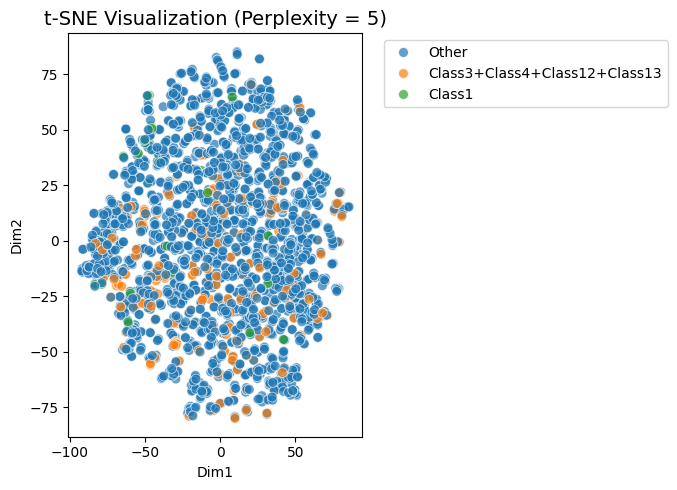


Running t-SNE with perplexity = 30 ...


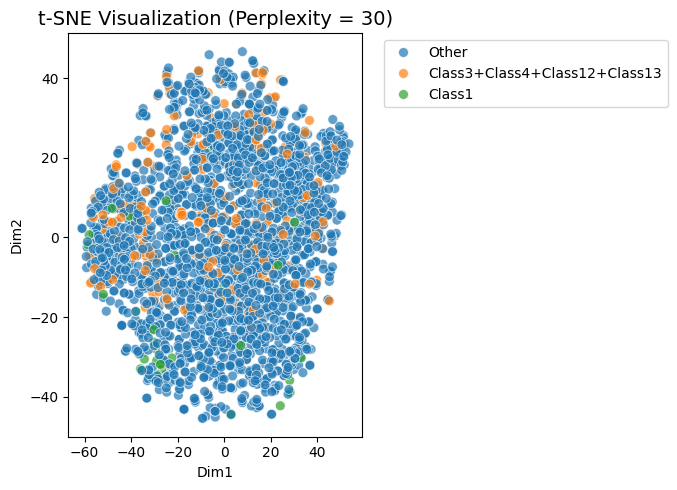


Running t-SNE with perplexity = 50 ...


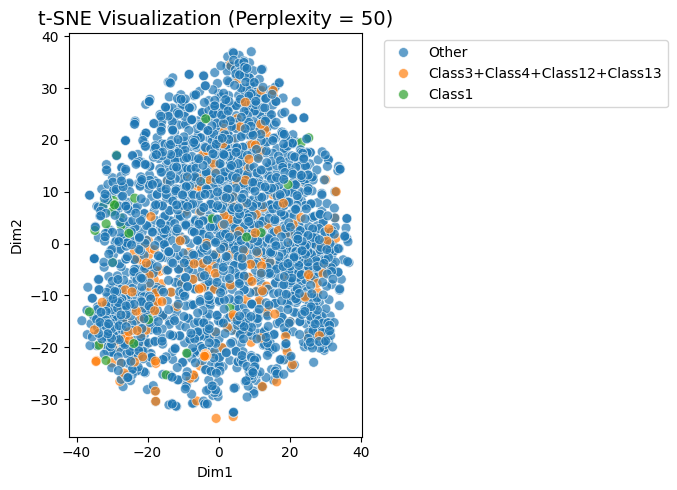

In [14]:
# 1. t-SNE Implementation: Apply t-Distributed Stochastic Neighbor Embedding (t-SNE) to the scaled feature matrix X to reduce it to 2 dimensions. Experiment with the perplexity hyperparameter (e.g., 5, 30, 50) and note how the visualization changes. Justify your final choice of perplexity.

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# --- Prepare Data ---
X_for_tsne = X_scaled.copy()
labels_for_tsne = X_viz["LabelGroup"]

# --- Try multiple perplexity values ---
perplexities = [5, 30, 50]
tsne_results = {}

for perp in perplexities:
    print(f"\nRunning t-SNE with perplexity = {perp} ...")
    tsne = TSNE(n_components=2, perplexity=perp, random_state=42, max_iter=1000)
    tsne_results[perp] = tsne.fit_transform(X_for_tsne)

    # --- Visualization ---
    tsne_df = pd.DataFrame(tsne_results[perp], columns=['Dim1', 'Dim2'])
    tsne_df["LabelGroup"] = labels_for_tsne.values

    plt.figure(figsize=(7,5))
    sns.scatterplot(
        data=tsne_df,
        x="Dim1", y="Dim2",
        hue="LabelGroup",
        palette="tab10",
        alpha=0.7,
        s=50
    )
    plt.title(f"t-SNE Visualization (Perplexity = {perp})", fontsize=14)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
